# Численные методы решения ОДУ на примере затухающего гармонического осциллятора #

На этом занятии мы реализуем и сравним ряд численных методов интегрирования:
- Метод Leapfrog-Verlet
- Метод Рунге-Кутты 
- Метод Адамса-Бэшфорта
- Метод Адамса-Моултона

Мы сравним их по точности и эффективности на примере затухающего гармонического осциллятора.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import matplotlib.animation as animation
from scipy.optimize import fsolve

from oscillator_plots import plots

## Уравнение гармонического осциллятора ##

Опишем затухающий гармонический осцилятор дифференциальным уравнением:

$$ m\ddot{u} + b\dot{u} + ku = 0 $$

где:
- $m$ — масса,
- $b$ — коэффициент трения,
- $k$ — жесткость пружины,
- $u$ — смещение.

Перепишем его в виде векторного дифферециального уравнения первого порядка:

$$\frac{d\vec{Y}}{dt} = \vec{F}(\vec{Y})$$

где вектор состояния:
$$\vec{Y} = \begin{pmatrix}u \\ v \end{pmatrix}$$

а векторная функция:
$$\vec{F}(\vec{Y}) = \begin{pmatrix} v \\ -\frac{k}{m} u - \frac{b}{m} v \end{pmatrix}$$

Физические параметры гармонического осциллятора

In [23]:
m = 1.0   # масса, кг
b = 0.01  # коэффициент трения, кг/с
k = 10.0  # жесткость пружины, Н/м

Начальные условия

In [24]:
u0 = 0.5   # начальное смещение, м
v0 = 0.0   # начальная скорость, м/с

Параметры интегрирования

In [25]:
T = 10.0     # время моделирования, с (уменьшили для жесткой системы)
dt = 0.1      # шаг интегрирования, с (уменьшили для стабильности Адамса)
n_steps = int(T/dt)   # число шагов

Массив времени

In [26]:
t = np.arange(0, T, dt)

print(f"Число шагов: {n_steps}")
print(f"Время моделирования: {T} с")
print(f"Шаг интегрирования: {dt} с")
print(f"Начальное смещение: {u0:.3f} м")
print(f"Начальная скорость: {v0:.3f} м/с")
print(f"Масса: {m:.1f} кг")
print(f"Жесткость пружины: {k:.1f} Н/м")
print(f"Коэффициент трения: {b:.1f} кг/с")

Число шагов: 100
Время моделирования: 10.0 с
Шаг интегрирования: 0.1 с
Начальное смещение: 0.500 м
Начальная скорость: 0.000 м/с
Масса: 1.0 кг
Жесткость пружины: 10.0 Н/м
Коэффициент трения: 0.0 кг/с


Функция полной энергии

In [27]:
def energy(u, v):
    """
    Расчет полной энергии гармонического осциллятора

    Args:
        x: смещение, м
        v: скорость, м/с

    Returns:
        E: полная энергия, Дж
    """
    # Потенциальная энергия
    U = 0.5 * k * u**2
    # Кинетическая энергия
    K = 0.5 * m * v**2
    return U + K

Решим наше уравнение несколькими методами и сравним их.

## Аналитическое решение задачи ##

Дифференциальное уравнение, которое мы моделируем, имеет классическое аналитическое решение через характеристическое уравнение. Для нашего дифференциального уравнения, характеристический многочлен - полином второго порядка. 

В зависимости от знака дискриминанта, выделяются три варианта:

1. При значении дискриминанта > 0 решение апериодическое. В этом случае колебания быстро экспоненциально затухают, и положение маятника не может пересечь 0 на конечном интервале.
2. При значении дискриминанта = 0 достигается граница апериодичности. 
3. При значении дискриминанта < 0 наблюдается слабое затухание. Гармонические колебания сохраняются вплоть до полного затухания.

In [28]:
def analytical_method(u0, v0, dt, n_steps):
    """
    Аналитическое решение для затухающего гармонического осциллятора

    Args:
        u0: начальное положение, м
        v0: начальная скорость, м/с
        dt: шаг времени
        n_steps: число шагов

    Returns:
        u_analytical: массив положений
        v_analytical: массив скоростей
    """

    T = n_steps*dt
    # Параметры затухающего осциллятора
    omega = np.sqrt(k / m)  # собственная частота
    gamma = b / (2 * m)      # коэффициент затухания

    # Определяем тип колебаний
    discriminant = gamma**2 - omega**2 

    t = np.arange(0, T, dt)

    if discriminant > 0:  # Экспоненциальное (апериодическое) затухание 
        alpha = np.sqrt(discriminant)
        A = u0
        B = (v0 + gamma * u0) / alpha

        u = np.exp(-gamma * t) * (A * np.cosh(alpha * t) + B * np.sinh(alpha * t))
        v = np.exp(-gamma * t) * ((-gamma * A + alpha * B) * np.cosh(alpha * t) +
                                  (-gamma * B + alpha * A) * np.sinh(alpha * t))

    elif discriminant < 0:  # Граница апериодичности
        alpha = np.sqrt(-discriminant)
        A = u0
        B = (v0 + gamma * u0) / alpha

        u = np.exp(-gamma * t) * (A * np.cos(alpha * t) + B * np.sin(alpha * t))
        v = np.exp(-gamma * t) * ((-gamma * A + alpha * B) * np.cos(alpha * t) +
                                  (-gamma * B - alpha * A) * np.sin(alpha * t))

    else:  # Слабое (гармоническое) затухание
        A = u0
        B = v0 + gamma * u0

        u = np.exp(-gamma * t) * (A + B * t)
        v = np.exp(-gamma * t) * (-gamma * A - gamma * B * t + B)

    return u, v

## Метод Рунге-Кутты ##

Метод Рунге-Кутты второго порядка (метод средней точки) использует две оценки производной:

1. **Первая оценка (в точке n):**
   $$\vec{k}_1 = \vec{F}(\vec{Y}_n)$$

2. **Вторая оценка (в средней точке):**
   $$\vec{k}_2 = \vec{F}\left(\vec{Y}_n + \vec{k}_1 \cdot \frac{\Delta t}{2}\right)$$

3. **Итоговое обновление:**
   $$\vec{Y}_{n+1} = \vec{Y}_n + \frac{\vec{k}_1 + \vec{k}_2}{2} \cdot \Delta t$$

In [29]:
def func_f(y):
    """ Функция изменения для затухающего гармонического осциллятора, принимает np.array(shape=2)"""
    u, v = y
    return np.array([
        v,
        -(k / m) * u - (b / m) * v,
    ])

Реализуем rk второго порядка

In [30]:
def rk2_method(u0, v0, dt, n_steps):
    """
    Метод Рунге-Кутты 2 порядка для гармонического осциллятора

    Args:
        u0: начальное положение, м
        v0: начальная скорость, м/с
        dt: шаг интегрирования, с
        n_steps: число шагов

    Returns:
        u: массив положений
        v: массив скоростей
    """
    y_state = np.zeros((n_steps, 2))

    y_state[0] = [u0, v0]

    for i in range(n_steps - 1):
        k1 = func_f(y_state[i])
        k2 = func_f(y_state[i] + k1 * dt)
        y_state[i+1] = y_state[i] + (k1 + k2) * dt / 2

    # Извлекаем смещение и скорость из состояния
    u = y_state[:, 0]
    v = y_state[:, 1]
    return u, v

и четвертого порядка

In [31]:
def rk4_method(u0, v0, dt, n_steps):
    """
    Метод Рунге-Кутты 4 порядка для гармонического осциллятора

    Args:
        u0: начальное положение, м
        v0: начальная скорость, м/с
        dt: шаг интегрирования, с
        n_steps: число шагов

    Returns:
        u: массив положений
        v: массив скоростей
    """
    y_state = np.zeros((n_steps, 2))

    y_state[0] = [u0, v0]

    for i in range(n_steps - 1):
        k1 = func_f(y_state[i])
        k2 = func_f(y_state[i] + k1 * dt/2)
        k3 = func_f(y_state[i] + k2 * dt/2)
        k4 = func_f(y_state[i] + k3 * dt)

        y_state[i+1] = y_state[i] + (k1 + 2*k2 + 2*k3 + k4) * dt / 6

    # Извлекаем смещение и скорость из состояния
    u = y_state[:, 0]
    v = y_state[:, 1]
    return u, v

## Метод Адамса-Бэшфорта ##

В отличие от одношаговых методов Рунге-Кутты, многошаговые методы Адамса-Бэшфорта используют **историю предыдущих шагов** для построения более точной аппроксимации производной.

**Основная идея**: Если мы знаем значения производной в нескольких предыдущих точках, мы можем экстраполировать её поведение вперед.

Метод использует линейную экстраполяцию производной на основе двух предыдущих точек:

**Экстраполяционная формула:**
$$\vec{F}_{n+1/2} \approx \frac{3}{2} \vec{F}_n - \frac{1}{2} \vec{F}_{n-1}$$

**Итоговое обновление:**
$$\vec{Y}_{n+1} = \vec{Y}_n + \frac{\Delta t}{2} \cdot \left(3\vec{F}_n - \vec{F}_{n-1}\right)$$

### Геометрическая интерпретация

Метод строит параболу через три точки производной (n-1, n, n+1) и использует её для предсказания следующего значения. В 2-порядковой версии используется только линейная экстраполяция.

### Особенности реализации

1. **Запуск метода**: Требуется минимум один предыдущий шаг
2. **Устойчивость**: Метод может быть неустойчивым для жестких систем
3. **Эффективность**: Более эффективен при фиксированной точности по сравнению с RK2
4. **Точность**: 2-й порядок точности при условии гладкости решения

In [32]:
def explicit_adams2_method(u0, v0, dt, n_steps):
    """
    Метод Адамса-Бэшфорта 2-го порядка для гармонического осциллятора

    Args:
        u0: начальное положение, м
        v0: начальная скорость, м/с
        dt: шаг интегрирования, с
        n_steps: число шагов

    Returns:
        u: массив положений
        v: массив скоростей
    """
    y_state = np.zeros((n_steps, 2))
    f_history = np.zeros((n_steps, 2))  # история производных

    y_state[0] = [u0, v0]
    f_history[0] = func_f(y_state[0])

    # Для старта метода Адамса нужен 1 предыдущий шаг
    # Используем RK2 вместо Эйлера для лучшего старта (Адамс-Бэшфорта часто неустойчив)
    if n_steps > 1:
        k1 = func_f(y_state[0])
        k2 = func_f(y_state[0] + dt * k1)
        y_state[1] = y_state[0] + (dt / 2) * (k1 + k2)
        f_history[1] = func_f(y_state[1])

    # Применяем метод Адамса-Бэшфорта 2-го порядка для оставшихся шагов
    for i in range(1, n_steps - 1):
        # Формула Адамса-Бэшфорта 2-го порядка:
        # y_{n+1} = y_n + (h/2) * (3*f_n - f_{n-1})
        y_state[i+1] = y_state[i] + (dt / 2) * (
            3 * f_history[i] -
            1 * f_history[i-1]
        )
        f_history[i+1] = func_f(y_state[i+1])

    # Извлекаем смещение и скорость из состояния
    u = y_state[:, 0]
    v = y_state[:, 1]
    return u, v

In [33]:
def explicit_adams4_method(u0, v0, dt, n_steps):
    """
    Метод Адамса-Бэшфорта 4-го порядка для гармонического осциллятора

    Args:
        u0: начальное положение, м
        v0: начальная скорость, м/с
        dt: шаг интегрирования, с
        n_steps: число шагов

    Returns:
        u: массив положений
        v: массив скоростей
    """
    y_state = np.zeros((n_steps, 2))
    f_history = np.zeros((n_steps, 2))  # история производных

    y_state[0] = [u0, v0]
    f_history[0] = func_f(y_state[0])

    # Для старта метода Адамса нужны 3 предыдущие точки
    # Используем RK4 для первых 3 шагов
    for i in range(min(3, n_steps - 1)):
        k1 = func_f(y_state[i])
        k2 = func_f(y_state[i] + k1 * dt/2)
        k3 = func_f(y_state[i] + k2 * dt/2)
        k4 = func_f(y_state[i] + k3 * dt)

        y_state[i+1] = y_state[i] + (k1 + 2*k2 + 2*k3 + k4) * dt / 6
        f_history[i+1] = func_f(y_state[i+1])

    # Применяем метод Адамса-Бэшфорта 4-го порядка для оставшихся шагов
    for i in range(3, n_steps - 1):
        # Формула Адамса-Бэшфорта 4-го порядка:
        # y_{n+1} = y_n + (h/24) * (55*f_n - 59*f_{n-1} + 37*f_{n-2} - 9*f_{n-3})
        y_state[i+1] = y_state[i] + (dt / 24) * (
            55 * f_history[i] -
            59 * f_history[i-1] +
            37 * f_history[i-2] -
            9 * f_history[i-3]
        )
        f_history[i+1] = func_f(y_state[i+1])

    # Извлекаем смещение и скорость из состояния
    u = y_state[:, 0]
    v = y_state[:, 1]
    return u, v

## Неявный метод Адамса-Моултона  (метод трапеций) ##

В отличие от явных методов Адамса-Бэшфорта, неявные методы Адамса-Моултона используют **интерполяцию назад**, включая в расчет производную в искомой точке n+1.

**Основная идея**: Построить интерполяционный полином, проходящий через известные точки производной, и использовать его для получения значения в будущей точке.

Метод трапеций является простейшим неявным методом и использует линейную интерполяцию производной:

**Интерполяционная формула:**
$$\vec{F}(t) \approx \vec{F}_n + \frac{\vec{F}_{n+1} - \vec{F}_n}{\Delta t} \cdot (t - t_n)$$

**Интегрирование от n до n+1:**
$$\vec{Y}_{n+1} = \vec{Y}_n + \int_{t_n}^{t_{n+1}} \vec{F}(t) \, dt \approx \vec{Y}_n + \frac{\Delta t}{2} \cdot (\vec{F}_n + \vec{F}_{n+1})$$

### Схема предиктор-корректор

Поскольку метод неявный, используется двухшаговая процедура:

1. **Предиктор**: Получаем грубую оценку следующего состояния
2. **Корректор**: Решаем нелинейное уравнение для точного значения

**Неявное уравнение:**
$$\vec{Y}_{n+1} - \vec{Y}_n - \frac{\Delta t}{2} \cdot (\vec{F}_n + \vec{F}(\vec{Y}_{n+1})) = 0$$

### Геометрическая интерпретация

Метод эквивалентен интегрированию под трапецией, построенной на значениях производной в точках n и n+1. Это обеспечивает более высокую точность по сравнению с явными методами.

### Особенности реализации

1. **Устойчивость**: Абсолютно устойчив для линейных систем
2. **Точность**: 2-й порядок точности, но выше устойчивость
3. **Вычислительная сложность**: Требует решения нелинейного уравнения на каждом шаге
4. **Сходимость**: Гарантирована для широкого класса задач

In [34]:
def implicit_adams2_method(u0, v0, dt, n_steps):
    """
    Неявный метод Адамса-Моултона 2-го порядка для гармонического осциллятора
    (метод трапеций)

    Args:
        u0: начальное положение, м
        v0: начальная скорость, м/с
        dt: шаг интегрирования, с
        n_steps: число шагов

    Returns:
        u: массив положений
        v: массив скоростей
    """

    y_state = np.zeros((n_steps, 2))
    f_history = np.zeros((n_steps, 2))  # история производных

    y_state[0] = [u0, v0]
    f_history[0] = func_f(y_state[0])

    # Применяем неявный метод Адамса-Моултона 2-го порядка с самого начала
    for i in range(n_steps - 1):
        if i == 0:
            # Для первого шага используем явный метод Эйлера как предиктор
            y_predict = y_state[i] + dt * f_history[i]
        else:
            # Для последующих шагов используем линейную экстраполяцию
            # y_predict = y_n + h * (3/2 * f_n - 1/2 * f_{n-1})
            y_predict = y_state[i] + dt * (1.5 * f_history[i] - 0.5 * f_history[i-1])

        # Корректор: решаем нелинейное уравнение метода трапеций
        # y_{n+1} = y_n + (h/2) * (f_n + f_{n+1})
        def implicit_eq(y_next):
            f_next = func_f(y_next)
            return y_next - y_state[i] - (dt / 2) * (f_history[i] + f_next)

        # Решаем нелинейное уравнение
        y_state[i+1] = fsolve(implicit_eq, y_predict)
        f_history[i+1] = func_f(y_state[i+1])

    # Извлекаем смещение и скорость из состояния
    u = y_state[:, 0]
    v = y_state[:, 1]
    return u, v

In [35]:
def implicit_adams4_method(u0, v0, dt, n_steps):
    """
    Неявный метод Адамса-Моултона 4-го порядка для гармонического осциллятора

    Args:
        u0: начальное положение, м
        v0: начальная скорость, м/с
        dt: шаг интегрирования, с
        n_steps: число шагов

    Returns:
        u: массив положений
        v: массив скоростей
    """
    from scipy.optimize import fsolve

    y_state = np.zeros((n_steps, 2))
    f_history = np.zeros((n_steps, 2))  # история производных

    y_state[0] = [u0, v0]
    f_history[0] = func_f(y_state[0])

    # Для старта метода Адамса нужны 3 предыдущие точки
    # Используем RK4 для первых 3 шагов
    for i in range(min(3, n_steps - 1)):
        k1 = func_f(y_state[i])
        k2 = func_f(y_state[i] + k1 * dt/2)
        k3 = func_f(y_state[i] + k2 * dt/2)
        k4 = func_f(y_state[i] + k3 * dt)

        y_state[i+1] = y_state[i] + (k1 + 2*k2 + 2*k3 + k4) * dt / 6
        f_history[i+1] = func_f(y_state[i+1])

    # Применяем неявный метод Адамса-Моултона 4-го порядка
    for i in range(3, n_steps - 1):
        # Предиктор: используем Адамса-Бэшфорта для оценки
        y_predict = y_state[i] + (dt / 24) * (
            55 * f_history[i] -
            59 * f_history[i-1] +
            37 * f_history[i-2] -
            9 * f_history[i-3]
        )

        # Корректор: решаем нелинейное уравнение
        # y_{n+1} = y_n + (h/24) * (9*f_{n+1} + 19*f_n - 5*f_{n-1} + f_{n-2})
        def implicit_eq(y_next):
            f_next = func_f(y_next)
            return y_next - y_state[i] - (dt / 24) * (
                9 * f_next +
                19 * f_history[i] -
                5 * f_history[i-1] +
                1 * f_history[i-2]
            )

        # Решаем нелинейное уравнение
        y_state[i+1] = fsolve(implicit_eq, y_predict)
        f_history[i+1] = func_f(y_state[i+1])

    # Извлекаем смещение и скорость из состояния
    u = y_state[:, 0]
    v = y_state[:, 1]
    return u, v    

## Метод Verlet-Leapfrog ##

Метод Verlet-Leapfrog основан на концепции **чередования сетки** с состояниями на целом и полуцелом шагах:

**Состояния на целом шаге (n, n+1, ...):**
- Смещение $u_n$
- Ускорение $a_n = -(k/m) u_n$

**Состояния на полуцелом шаге (n+1/2, n+3/2, ...):**
- Скорость $v_{n+1/2}$

### Расширенное векторное представление

**Вектор положения (на целом шаге):**
$$\vec{Y}_n = \begin{pmatrix} u_n \end{pmatrix}$$

**Вектор скорости (на полуцелом шаге):**
$$\vec{V}_{n+1/2} = \begin{pmatrix} v_{n+1/2} \end{pmatrix}$$

### Алгоритм метода:

1. **Вычисление скорости на полуцелом шаге:**
   $$\vec{V}_{n+1/2} = \vec{V}_{n-1/2} + \Delta t \cdot \vec{F}(\vec{Y}_n)$$

2. **Вычисление положения на целом шаге:**
   $$\vec{Y}_{n+1} = \vec{Y}_n + \Delta t \cdot \vec{G}(\vec{V}_{n+1/2})$$

### Симплектические свойства

Метод Leapfrog является **симплектическим**, что означает:
- Отличное сохранение энергии консервативных систем
- Сохранение фазового объема
- Стабильность при долгосрочном моделировании
- Геометрическая точность в фазовом пространстве

Метод дает точность второго порядка, однако за счет консервативности обычно превосходит любые RK и AB методы на длинном отрезке времени.

In [36]:
def func_u(v):
    """Функция для обновления положения (принимает скорость)"""
    return np.array([v])

In [37]:
def func_v(u, v_current=None):
    """
    Функция для обновления скорости (принимает положение и опционально текущую скорость для трения)
    Для диссипативных систем используем приближение с трением
    """
    x = u[0]
    if v_current is None:
        # Без трения (консервативный случай)
        return np.array([-(k / m) * x])
    else:
        # С трением (диссипативный случай)
        return np.array([-(k / m) * x - (b / m) * v_current])

In [38]:
def leapfrog_method(u0, v0, dt, n_steps):
    """
    Args:
        u0: начальное положение, м
        v0: начальная скорость, м/с
        dt: шаг интегрирования, с
        n_steps: число шагов

    Returns:
        u: массив положений
        v: массив скоростей
    """

    u_state = np.zeros((n_steps, 1))  # положение [x]
    v_state = np.zeros((n_steps, 1))  # скорость [v]
    v_half_state = np.zeros((n_steps, 1)) # скорость на полуцелом шаге

    u_state[0] = [u0]
    v_state[0] = [v0]

    v_half_state[0] = v_state[0] + func_v(u_state[0], v_state[0][0]) * dt / 2

    for i in range(n_steps - 1):
        # Шаг для положения
        u_state[i+1] = u_state[i] + func_u(v_half_state[i][0]) * dt
        # Шаг для скорости (с учетом трения на текущей скорости)
        v_half_state[i+1] = v_half_state[i] + func_v(u_state[i+1], v_half_state[i][0]) * dt

    v_state[1:] = (v_half_state[:-1] + v_half_state[1:])/2

    x = u_state[:, 0]
    v = v_state[:, 0]
    return x, v

## Решим задачи всеми методами ##

In [39]:
# Аналитическое решение
u_analytic, v_analytic = analytical_method(u0, v0, dt, n_steps)
energy_analytic = energy(u_analytic, v_analytic)

print(f"Начальная энергия (аналитическое решение): {energy_analytic[0]:.6f} Дж")
print(f"Конечная энергия (аналитическое решение): {energy_analytic[-1]:.6f} Дж")
print(f"Изменение энергии: {energy_analytic[-1] - energy_analytic[0]:.6f} Дж")
print(f"Коэффициент затухания: {b/(2*m):.3f} 1/с")

omega0 = np.sqrt(k/m)
gamma = b/(2*m)
if omega0 > gamma:
    print(f"Частота затухающих колебаний: {np.sqrt(omega0**2 - gamma**2):.3f} рад/с")
    print(f"Период затухающих колебаний: {2*pi/np.sqrt(omega0**2 - gamma**2):.3f} с")
else:
    print("Система находится в апериодическом режиме (критическое или перекритическое затухание)")


# Решение методом Leapfrog
u_leapfrog, v_leapfrog = leapfrog_method(u0, v0, dt, n_steps)
energy_leapfrog = energy(u_leapfrog, v_leapfrog)

# Решение методом Рунге-Кутты 2 порядка
u_rk2, v_rk2 = rk2_method(u0, v0, dt, n_steps)
energy_rk2 = energy(u_rk2, v_rk2)

# Решение методом Рунге-Кутты 4 порядка
u_rk4, v_rk4 = rk4_method(u0, v0, dt, n_steps)
energy_rk4 = energy(u_rk4, v_rk4)

# Решение методом Адамса 2-го порядка
u_adams2, v_adams2 = explicit_adams2_method(u0, v0, dt, n_steps)
energy_adams2 = energy(u_adams2, v_adams2)

# Решение методом Адамса 4-го порядка
u_adams4, v_adams4 = explicit_adams4_method(u0, v0, dt, n_steps)
energy_adams4 = energy(u_adams4, v_adams4)

# Решение методом Адамса-Моултона 2-го порядка (неявный)
u_adams_moulton2, v_adams_moulton2 = implicit_adams2_method(u0, v0, dt, n_steps)
energy_adams_moulton2 = energy(u_adams_moulton2, v_adams_moulton2)

# Решение методом Адамса-Моултона 4-го порядка (неявный)
u_adams_moulton4, v_adams_moulton4 = implicit_adams4_method(u0, v0, dt, n_steps)
energy_adams_moulton4 = energy(u_adams_moulton4, v_adams_moulton4)


# Подготавливаем данные для графиков
plot_data = [
    {
        'label': 'Leapfrog',
        'color': 'cyan',
        'u': u_leapfrog,
        'v': v_leapfrog,
        'e': energy_leapfrog
    },
    {
        'label': 'RK4',
        'color': 'orange',
        'u': u_rk4,
        'v': v_rk4,
        'e': energy_rk4
    },
    {
        'label': 'RK2',
        'color': 'orange',
        'u': u_rk2,
        'v': v_rk2,
        'e': energy_rk2
    },    
    {
        'label': 'Адамс-Бэшфорт-2',
        'color': 'purple',
        'u': u_adams2,
        'v': v_adams2,
        'e': energy_adams2
    },
    {
        'label': 'Адамс-Бэшфорт-4',
        'color': 'brown',
        'u': u_adams4,
        'v': v_adams4,
        'e': energy_adams4
    },
    {
        'label': 'Адамс-Моултон-2',
        'color': 'magenta',
        'u': u_adams_moulton2,
        'v': v_adams_moulton2,
        'e': energy_adams_moulton2
    },
    {
        'label': 'Адамс-Моултон-4',
        'color': 'cyan',
        'u': u_adams_moulton4,
        'v': v_adams_moulton4,
        'e': energy_adams_moulton4
    },
    {
        'label': 'Аналитика',
        'color': 'green',
        'u': u_analytic,
        'v': v_analytic,
        'e': energy_analytic
    }
]

Начальная энергия (аналитическое решение): 1.250000 Дж
Конечная энергия (аналитическое решение): 1.131790 Дж
Изменение энергии: -0.118210 Дж
Коэффициент затухания: 0.005 1/с
Частота затухающих колебаний: 3.162 рад/с
Период затухающих колебаний: 1.987 с


## Сравнение методов ##

Построим графики для сравнения методов второго порядка.


Начальная энергия (метод Leapfrog): 1.25 Дж
Конечная энергия (метод Leapfrog): 1.1322015559091578 Дж
Изменение энергии: -0.11779844409084217 Дж
Относительное изменение: -9.423875527267374%

Начальная энергия (метод RK4): 1.25 Дж
Конечная энергия (метод RK4): 1.1302896881770716 Дж
Изменение энергии: -0.11971031182292835 Дж
Относительное изменение: -9.576824945834268%

Начальная энергия (метод RK2): 1.25 Дж
Конечная энергия (метод RK2): 1.444504860823632 Дж
Изменение энергии: 0.19450486082363194 Дж
Относительное изменение: 15.560388865890557%

Начальная энергия (метод Адамс-Бэшфорт-2): 1.25 Дж
Конечная энергия (метод Адамс-Бэшфорт-2): 2.0528189197713775 Дж
Изменение энергии: 0.8028189197713775 Дж
Относительное изменение: 64.2255135817102%

Начальная энергия (метод Адамс-Бэшфорт-4): 1.25 Дж
Конечная энергия (метод Адамс-Бэшфорт-4): 1.0290160472810652 Дж
Изменение энергии: -0.22098395271893478 Дж
Относительное изменение: -17.678716217514783%

Начальная энергия (метод Адамс-Моултон-2): 1.2


Создание анимации в subplot...


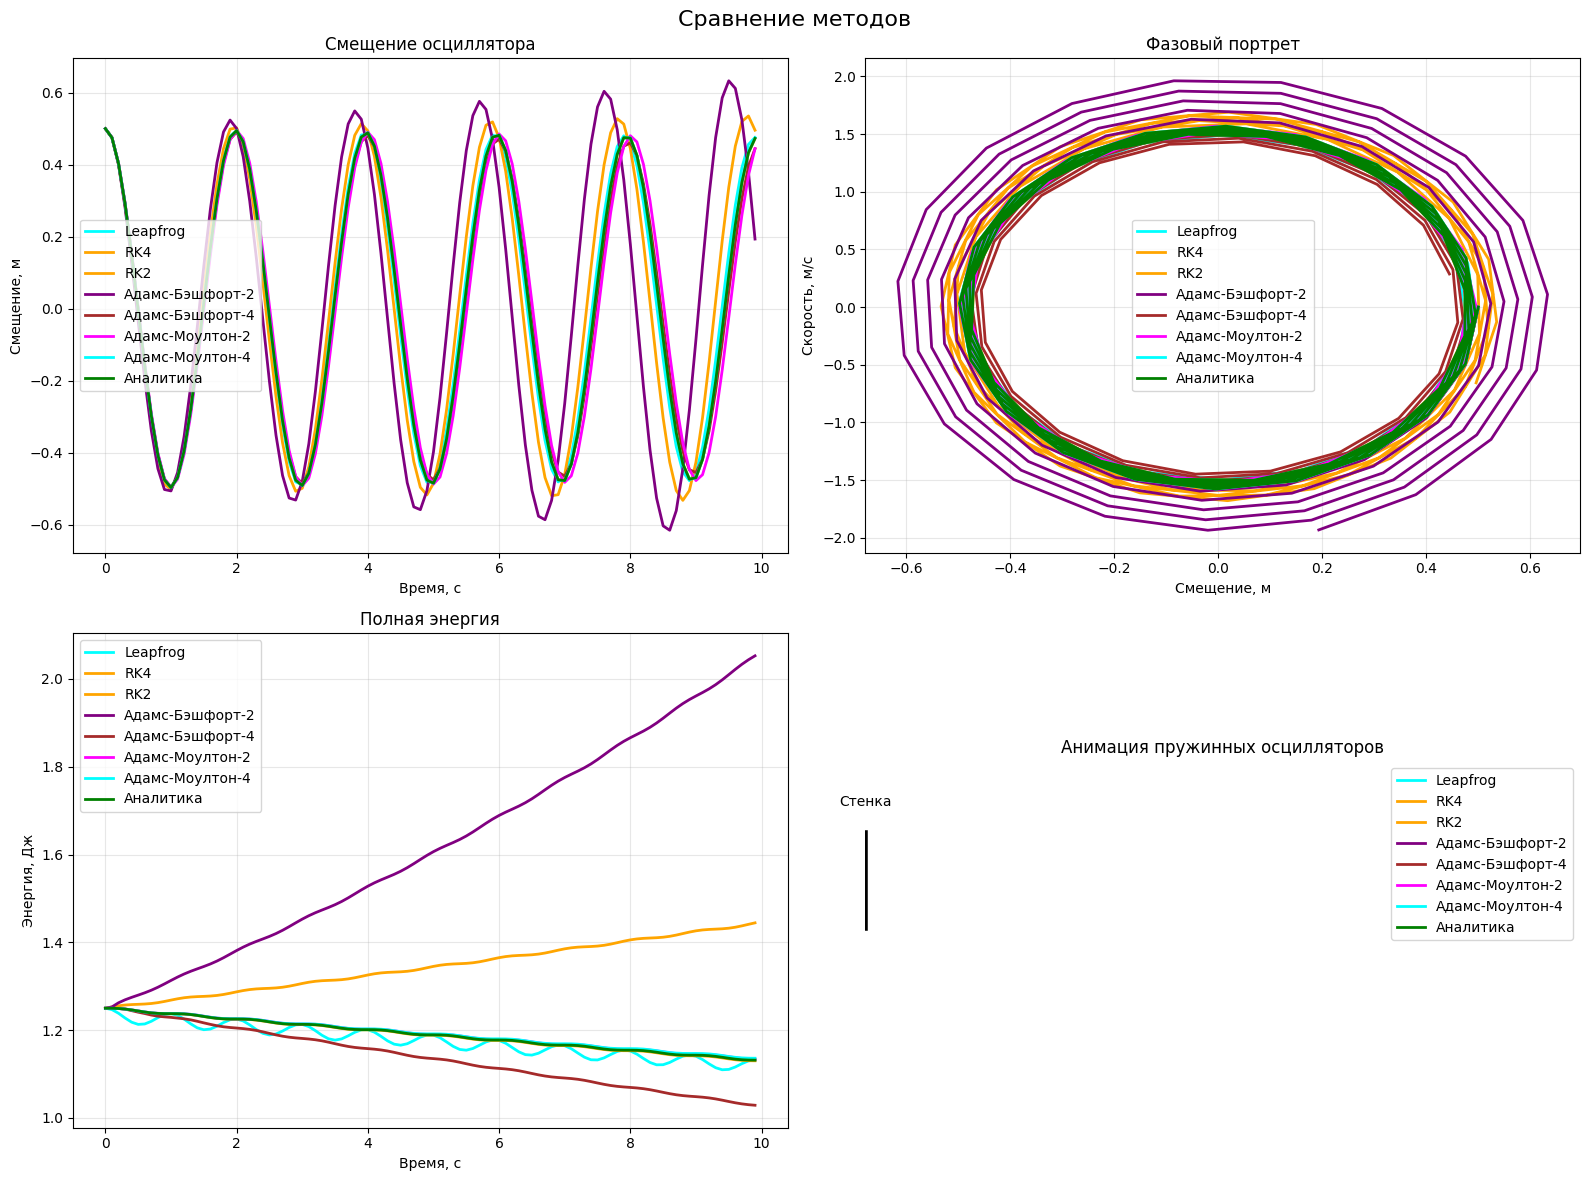

In [40]:
plots(t, T, plot_data)

Анимация осциляторов может не отображаться в режиме ноутбука. Вы можете посмотреть графики, запустив скрипт .py

## Выводы ##

На основе проведенного сравнения методов интегрирования для затухающего гармонического осциллятора можно сделать следующие выводы:

### По точности решения:
1. **Методы Рунге-Кутты (RK4)** - наиболее точный одношаговый метод
   - Отличная точность для широкого диапазона задач
   - Стабильный для различных типов систем

2. **Методы Адамса-Моултона (неявные)** - самые точные для жестких систем
   - Высокая точность и устойчивость
   - Требуют решения нелинейных уравнений на каждом шаге
   - 2-го порядка проще в реализации, но менее точный

3. **Методы Адамса-Бэшфорта (явные)** - эффективные многошаговые методы
   - Высокая точность при больших шагах интегрирования
   - Могут быть неустойчивыми для жестких систем

4. **Метод Leapfrog** - хорошая точность для консервативных систем
   - Симплектический, сохраняет структуру фазового пространства
   - Может иметь небольшие отклонения при сильном затухании

### Классификация методов интегрирования:

#### **Явные методы:**
- **Определение**: Новое значение решения вычисляется только через предыдущие значения
- **Примеры**: RK4, Адамса-Бэшфорта, Leapfrog
- **Преимущества**: Простота реализации, высокая скорость
- **Недостатки**: Могут быть неустойчивыми при больших шагах

#### **Неявные методы:**
- **Определение**: Новое значение решения входит в уравнение и требует решения нелинейной системы
- **Примеры**: Адамса-Моултона, методы Розенброка, BDF методы
- **Преимущества**: Устойчивость при больших шагах, хорошая сходимость
- **Недостатки**: Сложность реализации, требуют решения уравнений на каждом шаге

#### **Одношаговые vs Многошаговые:**
- **Одношаговые** (RK4): используют только текущую точку, самодостаточны
- **Многошаговые** (Адамса): используют историю нескольких предыдущих шагов
- **Преимущество многошаговых**: выше эффективность при фиксированной точности

### Рекомендации по применению:
- **Для высокой точности на коротких интервалах**: RK4
- **Для длинных расчетов с умеренной точностью**: Leapfrog
- **Для эффективных расчетов**: Адамса-Бэшфорта (явные)
- **Для жестких систем**: Адамса-Моултона (неявные)